## Validation

### Predictions on Never Before Seen Data

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR
from kss_df import KssDf, KssDfType
from kss_speech import KssSpeech
from audio import Audio
from filename_versioner import FilenameVersioner

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')


In [41]:
import joblib
from pipewrap import PipeWrap

# # Load
# # TODO: This is similar to in FilenameVersioner maybe move it there
# import glob
# import os
# def find_latest(f_glob, base_dir):
#     versions = glob.glob(f'{base_dir}/{f_glob}')
#     # early return
#     if len(versions) < 1:
#         return None, None
#
#     return max(versions, key=os.path.getctime)
#
# from filename_versioner import FilenameVersioner

# model_file = find_latest('svr_rbf*', tng_data_dir)
# kspeechs_file = find_latest('kspeech_trn_list*', tng_data_dir)

# print(model_file, kspeechs_file)

tng_data_dir = './data/model'
fv = FilenameVersioner(('svr_rbf', 'joblib'), base_dir=tng_data_dir )
fv_shared_params = FilenameVersioner(('shared_params', 'joblib'), base_dir=tng_data_dir)

print(fv.get_latest_path())
print(fv_shared_params.get_latest_path())

./data/model/svr_rbf.x0y0k0.0.joblib
./data/model/shared_params.2.joblib


In [42]:
# fv = FilenameVersioner((model_file, 'joblib'), base_dir=tng_data_dir )
model_file = fv.get_latest_path()
xy_version, tng_version = fv.get_latest_data()[1].split('.')
# kspeechs_version = kspeechs_file.split('.')[-2]
print(xy_version)
print(tng_version)
# print(kspeechs_version)

# Load Trained Model
# tng_data_dir = './data/model'
# svr_file = f'{tng_data_dir}/svr_trained.joblib'

# TODO: Make pipeline and put SlidingWindow transformer in pipeline, and save the pipeline as the model
model = joblib.load(model_file).pipe
# kspeechs = joblib.load(kspeechs_file)
# print(kspeechs)

# Load Training data (for comparison)
# rms_file = f'./data/model/rms_trn.joblib'
# (x_rms, y_rms) = joblib.load(rms_file)
# ap_trn_file =  f'./data/model/ap_trn.joblib'
# ap_trn = joblib.load(ap_trn_file)

x0y0k0
0


In [43]:
from kss_df import KssDf
from kss_speech import KssSpeech

kss_id = "1_0007"
# tg_dir = 'data/korean-single-speaker/kss'
#
# chunk_dir = 'data/korean-single-speaker/kss_chunks'
#
# markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
# markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')

# markers_char_df, markers_syl_df = KssChunk.load_all()
# markers_char = MarkerDf(markers_char_df)
# markers_syl = MarkerDf(markers_syl_df)
#
# print(markers_syl.df)

# def kss_speech_maker(kdf):
#     a = Audio(kdf.audio_path, n_fft=256, n_hops=4, n_mfcc=3)
#     # df = kdf.load_tg()
#     return KssSpeech(df, a, window=128, offset=64)


kdf_pred = KssDf(kss_id)
shared_params = joblib.load(fv_shared_params.get_latest_path())
audio_params = shared_params['audio']

from transformers import SlidingWindow
# a_orig = a = Audio(kdf.audio_path, n_fft=256, n_hops=4, n_mfcc=3)
# print(kdf_pred)

a_orig = Audio(kdf_pred.audio_path, **audio_params)
X_pred = a_orig.rms.flatten()
# sw_tng = kps['sw']
# print(sw_tng)
# sw_pred = SlidingWindow(window=sw_tng.window, offset=sw_tng.offset)
# X_pred= sw_pred.transform(a_orig.rms, None)
print(a_orig.rms.shape)
print(X_pred.shape)
# print(x_pred.X.shape[0] - a_orig.rms.shape[1])
# kspeech_pred = kss_speech_maker(kdf_pred)


Audio[WARNING]: Modifying input wav from size 154852 to 154880
Audio[INFO]: change in number of samples: 28 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2421, reduction factor 2420.0


(1, 2421)
(2421,)


In [44]:
# import math
# import librosa
# import numpy as np
# from log import Log
#
#
# a = Audio(kdf_pred.audio_path, n_fft=256, n_hops=4, n_mfcc=3)
# print(a)
#
# # # TODO Set up to use Audio rather that AudioPlexer
# # x_val_path = f'{tg_dir}/{kss_id}.wav'v
# # x_val_paths = [x_val_path]
# # ap_params_val = {
# #                     'n_fft': 256,
# #                     'n_hops':  4,
# #                     'sliding_window_size': 128,
# #                     'sliding_offset': 64
# #                 }
# #
# # #TODO: We will operate on single files so we should use Audio not AudioPlexer
# # # AudioPlexer: n audio files -> 1 TextGrid
# # # Audio: n audio files -> n TextGrids
# # disp.obj(x_val_paths, 'validation files')
# # ap = AudioPlexer(x_val_paths, **ap_params_val)
# # disp.audio(data=ap.wav(), rate=ap.sr)
# #
# # x_rms = ap.rms().flatten()
# # disp.obj(x_rms.shape, 'x_rms shape')

## Model Prediction

In [45]:
# X_pred = sw_pred.X

disp.obj(X_pred.shape, 'X_pred shape')
y_pred = model.predict(X_pred)
print(X_pred.shape)
print(y_pred.shape)
print(y_pred)


X_pred shape

(2421,)

(2421,)
(2421,)
[-0.35118874 -0.37036091 -0.41733111 ...  0.08674087  0.08448577
  0.0852915 ]


In [51]:
# # A bit of a hack to get the offset.
# # TODO: A better way is to save the AudioPlexer used for training
# calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
# sw_offset = model['sw'].window - model['sw'].offset
sw_offset = 0

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')
#
# def delta(y1, y2, y1_offset, y2_offset):
#     min_len = min(len(y1), len(y2))
#     return align(y1, y1_offset)[0:min_len] - align(y2, y2_offset)[0:min_len]
#
# def speech_base_delta(y, offset):
#     return delta(y, y_rms, offset, 0)
#
# # TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)
#
#
# def get_events_from_preds(preds):
#     pred_pad = np.pad(preds, (0,0), 'minimum')

{'label': 'Input Audio'}


Input Audio

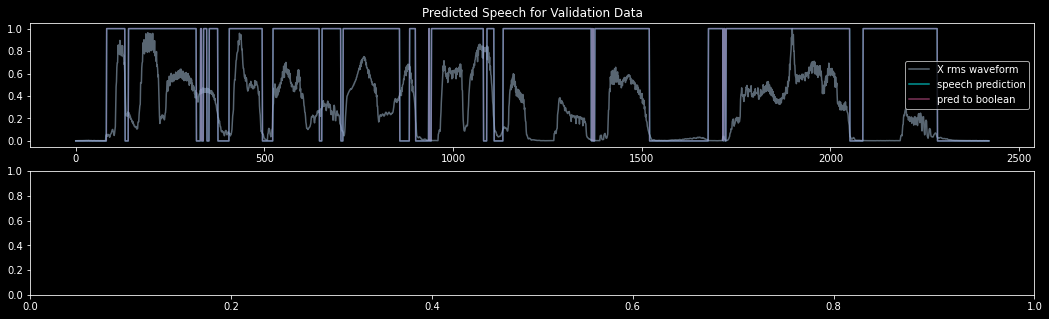

In [60]:
manual_offset1 = 0
manual_offset2 = 64
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,5))

y_pred_bool = pred_threshold(y_pred, 0.5)
ax1.set_title(f'Predicted Speech for Validation Data')
ax1.plot(X_pred, color='slategray', alpha=0.8, label='X rms waveform')
# ax1.plot(np.mean(X_pred, axis=1), color='slategray', alpha=0.8, label='sliding window mean')

ax1.plot(pred_threshold(align(y_pred, manual_offset1)), color='cyan', alpha=0.6, label='speech prediction')
# ax1.plot(align(y_pred, sw_offset), color='cyan', alpha=0.6, label='speech prediction')
ax1.plot(align(1*y_pred_bool, manual_offset1), color='hotpink', alpha=0.5, label='pred to boolean')
ax1.legend(loc='center right')

# ax2.set_title(f'Predicted Speech vs Manual Speech')
# # ax2.plot(a_orig.rms.squeeze(), color='lightblue', alpha=0.8, label='Manual')
# # ax2.plot(align(1*y_pred_bool, sw_offset), color='hotpink', alpha=0.5, label='Prediction')
# ax2.legend(loc='center right')
# plt.show()

disp.audio(data=a_orig.wav, rate=a_orig.sr, label='Input Audio')

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True])

Event Indices

array([  82,  131,  140,  320,  331,  334,  339,  348,  354,  377,  407,
        495,  523,  646,  653,  703,  709,  859,  885,  901,  936,  938,
        943, 1081, 1090, 1109, 1133, 1367, 1368, 1370, 1371, 1372, 1376,
       1521, 1677, 1716, 1717, 1721, 1724, 2052, 2087, 2284])

Event Vaues

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True])

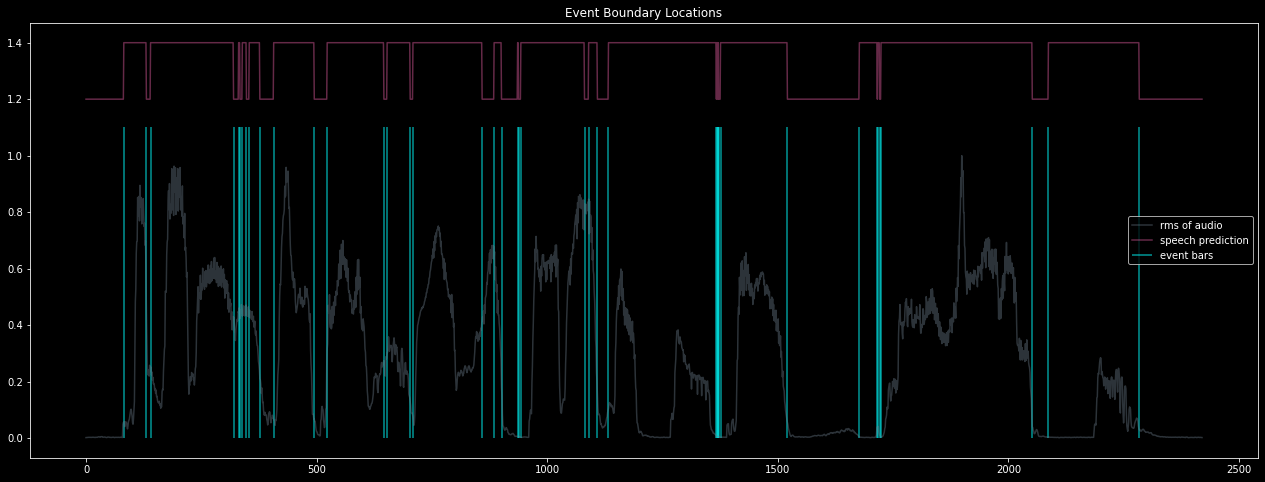

Speech Event_t

array([0.        , 0.11900227, 0.19011338, 0.2031746 , 0.46439909,
       0.48036281, 0.48471655, 0.49197279, 0.50503401, 0.5137415 ,
       0.54712018, 0.5906576 , 0.71836735, 0.75900227, 0.93750567,
       0.9476644 , 1.02022676, 1.02893424, 1.24662132, 1.28435374,
       1.3075737 , 1.35836735, 1.36126984, 1.36852608, 1.56879819,
       1.58185941, 1.60943311, 1.64426304, 1.98385488, 1.98530612,
       1.98820862, 1.98965986, 1.99111111, 1.9969161 , 2.20734694,
       2.4337415 , 2.49034014, 2.49179138, 2.49759637, 2.50195011,
       2.97795918, 3.02875283, 3.31464853])

In [62]:

#TODO: Figure out where to do final alignment
# y_train_pred_bool_align = align(y_train_pred_bool, sw_offset)
y_pred_bool_align = align(y_pred_bool, sw_offset)

# TODO: Move these to a class
def get_intervals(bs_in):
    bs = np.pad(bs_in, (1,1), 'edge')
    d = np.diff(bs)
    ivl_idxs = np.where(d > 0)[0]
    disp.obj(bs[ivl_idxs], 'Testing for Vals')
    return ivl_idxs, bs[ivl_idxs]

y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
disp.obj(y_pred_event_idxs, "Event Indices")
disp.obj(y_pred_event_vals, "Event Vaues")


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(X_pred, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(align(0.2*y_pred_bool+1.2, manual_offset1), color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_pred_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_pred_event_t = y_pred_event_idxs  * (a_orig.hop_length/a_orig.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_pred_event_t, (1, 0), constant_values=0.0)
disp.obj(speech_event_t, "Speech Event_t")

In [49]:
def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')
#Prediction into TextGrid
# need kss_id, xy_version, tng_version to save prediction file
# y_pred_vals for event markers to go to textgrid

# # X_val, _ = ap.sliding_window_features(x_rms, y=y_rms)
# X_val, _ = ap.sliding_window_features(x_rms, y=y_rms)
#
# disp.obj(X_val.shape, 'X_val shape')
# y_pred = model.predict(X_val)
#
# # A bit of a hack to get the offset.
# # TODO: A better way is to save the AudioPlexer used for training
# calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
# sw_offset = 64 # calc_offset


y_pred_bool = pred_threshold(y_pred, 0.5)
y_pred_bool_align = align(y_pred_bool, sw_offset)
y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
# tg_pred_path = f'{tg_dir}/{kss_id}.pred.{xy_version}.{tng_version}.TextGrid'
tg_pred_path = kdf_pred.tg_pred_path(xy_version, tng_version)
# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

# TODO: Combine vals into src, for tighter coupling
def make_textgrid(src, vals):
    ivl_template = string.Template(Path('./template/interval.template').read_text())
    item_template = string.Template(Path('./template/item.template').read_text())
    item_list_template = string.Template(Path('./template/itemlist.template').read_text())
    textgrid_template = string.Template(Path('./template/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': f'{vals[i]}' if vals is not None else ' '
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, vals, tg_pred_path):
    with open(tg_pred_path, 'w') as f:
        print(f'saving textgrid to {tg_pred_path}')
        f.write(make_textgrid(src, vals))

tg_vals = np.where(y_pred_event_vals, ' ', '0')
textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
print('Check to see if save is commented or not')
# save_textgrid(textgrid_src, tg_vals, tg_pred_path)

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True])

Check to see if save is commented or not


In [50]:
# # Validation
# import pandas as pd
# from kss_textgrid import KssTextGrid
# # TODO: Compare Predicted vs Actual TextGrid
#
# tg_dir = 'data/korean-single-speaker/kss/1'
# # tg_file = '1_0003.TextGrid'
# # audio_file = '1_0003.wav'
# # tg_path = f'{tg_dir}/{tg_file}'
# # audio_path = f'{tg_dir}/{audio_file}'
# # print(tg_path)
# # tg = textgrid.TextGrid.fromFile(tg_path)
# val_kss_id = '1_0005'
#
# syls_df_pred = KssTextGrid(val_kss_id, tg_dir, path=tg_pred_path).syls_df()
# disp.obj(syls_df_pred[syls_df_pred['syl'] == '0'], f'Predicted Syl DF for {val_kss_id}')
#
# assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')
#
# syls_df_actual = KssTextGrid(val_kss_id, tg_dir).syls_df()
# disp.obj(syls_df_actual[syls_df_actual['syl'] == '0'], f'Actual Syl DF for {val_kss_id}')